In [1]:
import transformers
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'

gpt2 = transformers.GPT2LMHeadModel.from_pretrained("openai-community/gpt2").to("cuda")
gpt2_tokenizer = transformers.GPT2Tokenizer.from_pretrained("openai-community/gpt2")

# Step 1: Remove `elementwise_affine`

In [2]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

To get rid of elementwise_affine, we must first understand what it does:
$$
\operatorname{LayerNorm}(x) = \frac{x - \mathbb{E}[x]}{\sqrt{\operatorname{Var}[x] + \epsilon}} * \gamma + \beta
$$
Where $\gamma, \beta \in \mathbb R^{d_{model}}$. Thus we can try to fix this moving from the last layer to the first. Starting from the unembedding, we can just subtract $\beta$ from each of the unembedding parameters, and then divide the unembedding weights by $\gamma$.

In [2]:
gpt2.transformer.h[-1]

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [4]:
# can we get rid of elementwise_affine?
gpt2.transformer.h[0].ln_1.weight.shape

torch.Size([768])

In [5]:
gpt2.lm_head.weight.shape

torch.Size([50257, 768])

In [6]:
gpt2.transformer.h[-1].mlp.c_fc.weight.shape

torch.Size([768, 3072])

In [3]:
import torch

In [8]:
"""
residual = hidden_states
hidden_states = self.ln_2(hidden_states)
feed_forward_hidden_states = self.mlp(hidden_states)
# residual connection
hidden_states = residual + feed_forward_hidden_states
"""

ln_non_affine = torch.nn.LayerNorm(normalized_shape=(768,)).to('cuda')

inp = torch.arange(768, device='cuda').float()

ln = gpt2.transformer.h[-1].ln_2
with torch.no_grad():
    r = (ln(inp) - ln.bias)/ln.weight
torch.allclose(r, ln_non_affine(inp))

True

In [9]:
lnw_orig = ln.weight.clone()
lnb_orig = ln.bias.clone()

In [11]:
weight_orig = gpt2.transformer.h[-1].mlp.c_fc.weight.clone()
bias_orig = gpt2.transformer.h[-1].mlp.c_fc.bias.clone()

In [13]:
gpt2.transformer.h[-1].mlp.c_fc(ln.bias).shape

torch.Size([3072])

In [14]:
ln = gpt2.transformer.h[-1].ln_2
weight_rescaled = weight_orig * lnw_orig.unsqueeze(-1)
fc = gpt2.transformer.h[-1].mlp.c_fc
gpt2.transformer.h[-1].mlp.c_fc.weight.data = weight_rescaled
gpt2.transformer.h[-1].mlp.c_fc.bias.data = bias_orig + weight_orig.T @ lnb_orig
print(weight_orig.T@lnb_orig, fc(lnb_orig) - bias_orig)
gpt2.transformer.h[-1].ln_2.elementwise_affine = False
with torch.no_grad():
    gpt2.transformer.h[-1].ln_2.weight[:] = 1
    gpt2.transformer.h[-1].ln_2.bias[:] = 0
with torch.no_grad():
    result_rescaled = gpt2(**gpt2_tokenizer("hello world!", return_tensors='pt').to('cuda'))
result_rescaled.logits

tensor([-0.0647,  0.3438,  0.5384,  ..., -0.1176, -0.1933, -0.2486],
       device='cuda:0', grad_fn=<MvBackward0>) tensor([-0.0379,  0.4127,  0.6849,  ..., -0.0568, -0.1684, -0.2452],
       device='cuda:0', grad_fn=<SubBackward0>)


tensor([[[ -37.0708,  -36.4855,  -40.3520,  ...,  -46.5168,  -45.4142,
           -37.9090],
         [ -69.5277,  -65.2476,  -74.2180,  ...,  -80.8885,  -76.5055,
           -70.8534],
         [ -93.6960,  -93.7839,  -94.6315,  ..., -104.1838, -102.1104,
           -89.3226]]], device='cuda:0')

In [15]:
gpt2.transformer.h[-1].mlp.c_fc.weight.data = weight_orig
gpt2.transformer.h[-1].mlp.c_fc.bias.data = bias_orig
gpt2.transformer.h[-1].ln_2.elementwise_affine = True
with torch.no_grad():
    gpt2.transformer.h[-1].ln_2.weight[:] = lnw_orig
    gpt2.transformer.h[-1].ln_2.bias[:] = lnb_orig
with torch.no_grad():
    result_orig = gpt2(**gpt2_tokenizer("hello world!", return_tensors='pt').to('cuda'))
result_orig.logits

tensor([[[ -37.0708,  -36.4855,  -40.3520,  ...,  -46.5168,  -45.4142,
           -37.9090],
         [ -69.5277,  -65.2476,  -74.2180,  ...,  -80.8885,  -76.5055,
           -70.8534],
         [ -93.6960,  -93.7839,  -94.6315,  ..., -104.1838, -102.1104,
           -89.3226]]], device='cuda:0')

In [16]:
result_rescaled.logits - result_orig.logits

tensor([[[-3.8147e-06,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -3.8147e-06, -3.8147e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  7.6294e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]], device='cuda:0')

In [10]:
def remove_elementwise_affine_2(tblock):
    ln2 = tblock.ln_2
    fc1 = tblock.mlp.c_fc
    with torch.no_grad():
        weight_orig = fc1.weight.data.clone()
        fc1.weight.data = fc1.weight * ln2.weight.unsqueeze(-1)
        fc1.bias.data = fc1.bias + weight_orig.T @ ln2.bias.data
        ln2.elementwise_affine = False
        ln2.weight[:] = 1
        ln2.bias[:] = 0


In [18]:
for i in range(len(gpt2.transformer.h)):
    remove_elementwise_affine_2(gpt2.transformer.h[i])

In [19]:
with torch.no_grad():
    print(gpt2(**gpt2_tokenizer("hello world!", return_tensors='pt').to('cuda')).logits - result_orig.logits)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.8147e-06,
           0.0000e+00, -7.6294e-06],
         [ 0.0000e+00, -7.6294e-06, -7.6294e-06,  ..., -7.6294e-06,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  7.6294e-06,  0.0000e+00,  ...,  7.6294e-06,
           7.6294e-06,  0.0000e+00]]], device='cuda:0')


## Result

We were able to undo the notion of `elementwise_affine` for the second LayerNorm. The nice thing is that the whole residual stream doesn't seem to get layernorm'd here, which is sort of surprising actually and I'm not sure if it will need to be modified for other networks


## Removing `ln1`'s `elementwise_affine`

We will do this by modifying the `c_attn` affine transformations


In [9]:
def remove_elementwise_affine_1(tblock):
    ln = tblock.ln_1
    fc = tblock.attn.c_attn
    with torch.no_grad():
        weight_orig = fc.weight.data.clone()
        fc.weight.data = fc.weight * ln.weight.unsqueeze(-1)
        fc.bias.data = fc.bias + weight_orig.T @ ln.bias.data
        ln.elementwise_affine = False
        ln.weight[:] = 1
        ln.bias[:] = 0


In [21]:
tblock = gpt2.transformer.h[-1]
Wa_orig = tblock.attn.c_attn.weight.clone()
ba_orig = tblock.attn.c_attn.bias.clone()
ln1w_orig = tblock.ln_1.weight.clone()
ln1b_orig = tblock.ln_1.bias.clone()

In [22]:
ln = tblock.ln_1
fc = tblock.attn.c_attn
with torch.no_grad():
    weight_orig = fc.weight.data.clone()
    fc.weight.data = fc.weight * ln.weight.unsqueeze(-1)
    fc.bias.data = fc.bias + weight_orig.T @ ln.bias.data
    ln.elementwise_affine = False
    ln.weight[:] = 1
    ln.bias[:] = 0
    
with torch.no_grad():
    result_fixed_attn = gpt2(**gpt2_tokenizer("hello world!", return_tensors='pt').to('cuda'))

# gpt2.transformer.h[-1].attn.c_attn.weight.shape

In [23]:
(result_fixed_attn.logits - result_orig.logits).abs().max()

tensor(3.4332e-05, device='cuda:0')

In [24]:
for i in range(len(gpt2.transformer.h)):
    remove_elementwise_affine_1(gpt2.transformer.h[i])

In [25]:
with torch.no_grad():
    result_fixed_attn_all = gpt2(**gpt2_tokenizer("hello world!", return_tensors='pt').to('cuda'))
    
(result_fixed_attn_all.logits - result_orig.logits).abs().max()

tensor(3.8147e-05, device='cuda:0')

In [26]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=False)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=False)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Result

So it seems like we could remove almost all of the elementwise affine operations! There's a final `ln_f` which we will remove now. (Note that even though it says `bias=False` there *is* actually a bias because of the `ln_f`!)


In [29]:
gpt2.lm_head.weight.shape, gpt2.lm_head.bias

(torch.Size([50257, 768]), None)

In [14]:
def remove_ln_f(model):
    # there is originally no bias here
    ln = model.transformer.ln_f
    fc = model.lm_head
    
    '''
    gpt2.transformer:
    hidden_states = self.ln_f(hidden_states)
    hidden_states = hidden_states.view(output_shape)
    '''
    
    with torch.no_grad():
        weight_orig = fc.weight.data.clone()
        # needs to be done because weights are "tied" by HuggingFace
        # (they point to the same thing as the original embedding matrix)
        fc.weight = torch.nn.Parameter(fc.weight * ln.weight)
        fc.bias = torch.nn.Parameter(weight_orig @ ln.bias.data.clone())

        ln.elementwise_affine = False
        ln.weight[:] = 1
        ln.bias[:] = 0


In [35]:
gpt2.lm_head(gpt2.transformer.ln_f(torch.arange(768, device='cuda').float()))

tensor([ 4.7654,  6.5866,  1.7553,  ...,  9.5762, 15.3242,  6.8427],
       device='cuda:0', grad_fn=<SqueezeBackward4>)

In [6]:
gpt2 = transformers.GPT2LMHeadModel.from_pretrained("openai-community/gpt2").to("cuda")
gpt2_orig = transformers.GPT2LMHeadModel.from_pretrained("openai-community/gpt2").to("cuda")
gpt2_tokenizer = transformers.GPT2Tokenizer.from_pretrained("openai-community/gpt2")

lnf_b_orig = gpt2.transformer.ln_f.bias.clone()
lnf_W_orig = gpt2.transformer.ln_f.weight.clone()
lmh_W_orig = gpt2.lm_head.weight.clone()


In [12]:
def clean(gpt2):
    for i in range(12):
        remove_elementwise_affine_1(gpt2.transformer.h[i])
        remove_elementwise_affine_2(gpt2.transformer.h[i])
    remove_ln_f(gpt2)

In [7]:
@torch.no_grad()
def sample(gpt2):
    return gpt2(**gpt2_tokenizer("hello world!", return_tensors='pt').to('cuda'), output_hidden_states=True)

In [16]:
gpt2.lm_head.bias = None
gpt2.load_state_dict(gpt2_orig.state_dict())

clean(gpt2)

result_finale = sample(gpt2)
result_orig = sample(gpt2_orig)

(result_finale.logits - result_orig.logits).abs().max()

tensor(5.3406e-05, device='cuda:0')

In [17]:
result_orig.hidden_states[-1]

tensor([[[-0.0617,  0.0007, -0.3006,  ..., -0.1671, -0.0038, -0.1409],
         [-0.2276,  0.0651, -0.1504,  ..., -0.1922, -0.1107,  0.2989],
         [ 0.0478, -0.2524, -0.1154,  ..., -0.0455, -0.0334,  0.0451]]],
       device='cuda:0')

In [18]:
result_orig.logits

tensor([[[ -37.0708,  -36.4855,  -40.3520,  ...,  -46.5168,  -45.4142,
           -37.9090],
         [ -69.5277,  -65.2476,  -74.2180,  ...,  -80.8885,  -76.5055,
           -70.8534],
         [ -93.6960,  -93.7839,  -94.6315,  ..., -104.1838, -102.1104,
           -89.3226]]], device='cuda:0')

In [90]:
gpt2.lm_head((result_orig.hidden_states[-1] - lnf_b_orig) / lnf_W_orig)

tensor([[[ -37.0708,  -36.4855,  -40.3520,  ...,  -46.5168,  -45.4142,
           -37.9090],
         [ -69.5277,  -65.2476,  -74.2180,  ...,  -80.8885,  -76.5055,
           -70.8534],
         [ -93.6960,  -93.7838,  -94.6315,  ..., -104.1838, -102.1103,
           -89.3226]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [91]:
gpt2.transformer.wte.weight - gpt2_orig.transformer.wte.weight

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [19]:
result_orig.hidden_states[0], result_finale.hidden_states[0]

(tensor([[[-0.1007, -0.3921,  0.0049,  ..., -0.2066,  0.0256,  0.0360],
          [-0.1248,  0.0981, -0.0892,  ..., -0.2765,  0.2175,  0.0375],
          [-0.1059, -0.1240,  0.0876,  ..., -0.1166,  0.0344,  0.0239]]],
        device='cuda:0'),
 tensor([[[-0.1007, -0.3921,  0.0049,  ..., -0.2066,  0.0256,  0.0360],
          [-0.1248,  0.0981, -0.0892,  ..., -0.2765,  0.2175,  0.0375],
          [-0.1059, -0.1240,  0.0876,  ..., -0.1166,  0.0344,  0.0239]]],
        device='cuda:0'))

In [93]:
result_finale.hidden_states[-1]

tensor([[[-0.0450, -0.0261, -0.1236,  ..., -0.1423,  0.0198, -0.1453],
         [-0.1637,  0.0208, -0.0440,  ..., -0.1650, -0.0776,  0.2191],
         [ 0.0334, -0.2102, -0.0255,  ..., -0.0321, -0.0072,  0.0088]]],
       device='cuda:0')

In [94]:
result_finale.logits

tensor([[[ -37.0708,  -36.4855,  -40.3520,  ...,  -46.5168,  -45.4142,
           -37.9090],
         [ -69.5277,  -65.2476,  -74.2180,  ...,  -80.8885,  -76.5055,
           -70.8534],
         [ -93.6960,  -93.7838,  -94.6315,  ..., -104.1838, -102.1103,
           -89.3226]]], device='cuda:0')

In [95]:
gpt2.lm_head.bias

Parameter containing:
tensor([ -6.3267,  -6.1134,  -8.2121,  ..., -11.1459, -10.8880,  -6.1064],
       device='cuda:0', requires_grad=True)

In [98]:
(result_finale.hidden_states[-1] * lnf_W_orig + lnf_b_orig), (result_orig.hidden_states[-1])

(tensor([[[-0.0617,  0.0007, -0.3006,  ..., -0.1671, -0.0038, -0.1409],
          [-0.2276,  0.0651, -0.1504,  ..., -0.1922, -0.1107,  0.2989],
          [ 0.0478, -0.2524, -0.1154,  ..., -0.0455, -0.0334,  0.0451]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[-0.0617,  0.0007, -0.3006,  ..., -0.1671, -0.0038, -0.1409],
          [-0.2276,  0.0651, -0.1504,  ..., -0.1922, -0.1107,  0.2989],
          [ 0.0478, -0.2524, -0.1154,  ..., -0.0455, -0.0334,  0.0451]]],
        device='cuda:0'))

## Result

We have shown that we can effectively remove the `elementwise_affine` component of each LayerNorm. This will make the relationships between intermediate activations significantly more linear.


## Causal relationships

Let's see if we can compare correlations between MLP activations. (Using these improved matrices) So we might expect that we have bigram relationships modeled between the lm head and the word embeddings. Can also see the relationship between positional encodings and each word.

In [20]:
torch.set_grad_enabled(False)

In [109]:
bigram_corr_matrix = gpt2.lm_head.weight @ gpt2.transformer.wte.weight.T

In [110]:
pos_corr_matrix = gpt2.lm_head.weight @ gpt2.transformer.wpe.weight.T

In [111]:
pos_corr_matrix

tensor([[-2.5471e+00, -5.4091e+00, -2.3274e+00,  ..., -7.3445e+00,
         -7.6868e+00, -1.1570e-02],
        [-1.1365e+00, -4.7076e+00, -1.4911e+00,  ..., -6.9785e+00,
         -7.1958e+00, -2.4630e-03],
        [-1.3125e+00, -4.2784e+00, -1.3093e+00,  ..., -7.3957e+00,
         -7.5783e+00, -1.6481e-02],
        ...,
        [-4.8832e+00, -4.9813e+00, -1.7743e+00,  ..., -7.5792e+00,
         -7.7585e+00, -1.5871e-02],
        [-4.2381e+00, -6.3743e+00, -3.3911e+00,  ..., -8.2380e+00,
         -8.5629e+00,  1.1326e-02],
        [-1.4537e+00, -6.3225e+00, -2.9076e+00,  ..., -6.4535e+00,
         -6.7289e+00, -5.0177e-03]], device='cuda:0')

In [142]:
ranked = pos_corr_matrix[:, 0].argsort(descending=True)
for i in range(10):
    print(gpt2_tokenizer.decode(ranked[i]))

ignty
wcsstore
�
estone
ignt
���
eg
arest
ebook
estones


In [179]:
# Result for using the transformed weights
ids = gpt2_tokenizer("A").input_ids
print(ids)
tok = ids[0]
ranked = bigram_corr_matrix[:, tok].argsort(descending=True)
for i in range(10):
    token = gpt2_tokenizer.decode(ranked[i])
    similarity = bigram_corr_matrix[ranked[i], tok].item()
    print(f">{token} {similarity:.2f}")

[32]
>A 17.77
>ccording 16.88
> challeng 16.65
> mathemat 16.59
> destro 16.34
> conduc 16.24
> corrid 16.21
> helicop 16.11
> unden 15.93
> misunder 15.92


In [184]:
with torch.no_grad():
    ids = gpt2_tokenizer("A").input_ids
    print(ids)
    tok = ids[0]
    bigram_corr_matrix_orig = gpt2.transformer.wte.weight @ gpt2.transformer.wte.weight.T[:, tok]

    ranked = bigram_corr_matrix_orig.argsort(descending=True)
    for i in range(10):
        token = gpt2_tokenizer.decode(ranked[i])
        similarity = bigram_corr_matrix_orig[ranked[i]].item()
        print(f">{token} {similarity:.2f}")


[32]
>A 8.25
> A 5.61
>An 5.50
>a 5.36
>E 5.31
>The 5.29
>B 5.24
>I 5.24
>C 5.18
>D 5.09


# Step 2. See What Causes Different Outputs

Now, we can represent any intermediate hidden state as a weighted sum of the MLP neuron activations that came before. And in fact, we can anticipate the activation of any given attention head solely as a function of which MLP neurons were active beforehand, and **avoid using the residual stream at all**!

As a simple example, we can do the reverse of the ranking scheme I showed before, and try to find which words *induce* other words to be output.

But it doesn't seem like there's a ton of insight here.


In [201]:
# Result for using the transformed weights
ids = gpt2_tokenizer("al").input_ids
print(ids)
tok = ids[0]
ranked = bigram_corr_matrix[tok, :].argsort(descending=True)
for i in range(10):
    token = gpt2_tokenizer.decode(ranked[i])
    similarity = bigram_corr_matrix[tok, ranked[i]].item()
    print(f">{token} {similarity:.2f}")

[282]
>al 22.82
>alist 19.45
>aler 18.43
>alis 18.16
>als 17.80
>alam 17.44
>aled 17.29
>alm 17.22
>AL 17.22
>aling 17.20


In [212]:
# del bigram_corr_matrix
# del pos_corr_matrix
torch.cuda.empty_cache()

In [216]:
causality = gpt2.lm_head.weight @ gpt2.transformer.h[0].mlp.c_proj.weight.T

In [218]:
causality.shape

torch.Size([50257, 3072])

## Tracing what causes MLP neurons to activate

To do this, we will need to search for semi-linear correlations. I think that the relationships between many of these things are quite complex. However maybe we can look at value matrices and see.

I think first I'll look at what causes a given attention head to activate. We can reason about this via gradients.

$$
\alpha_{qk} = (W_{hq}X_q)^\top(W_{hk}X_k)
$$

We now operate under the knowledge that *all* residual states can be expressed in the form:
$$
\operatorname{ResidualStream^{(\ell)}} = \operatorname{LayerNorm}\left(
    \operatorname{WordEmbed}(\operatorname{Word}(k)) + \operatorname{PosEmbed}(k) + 
    \sum_{\ell = 0}^{L} \sum_{j = 0}^{d_{hidden}} \operatorname{MLPActivation}^{(\ell)}_j \operatorname{MLPEmbedding}^{(\ell)}_j
\right)
$$

Wherein Word(k) represents the token ID at index $k$, and the MLPActivation/MLPEmbedding expressions represent hidden states in the MLP.

We note that the inner term is now a linear function of Word(k), PosEmbed(k), and MLPActivation$_j^{(\ell)}$. Therefore, we can try to compile this hidden state into $S^{(\ell)}$, abbreviating "(s)parse state", along with a weight matrix to project into the residual stream. Let's denote $W_{xs}$ as a weight matrix that converts from the sparse state representation into the compressed representation used in the residual stream:
$$
X^{(\ell)} = \operatorname{ResidualStream}^{(\ell)} = \operatorname{LayerNorm}\left( W_{xs} S^{(\ell)} \right)
$$
We note that this is (very nearly) a linear function of $S^{(\ell)}$, as LayerNorm simply scales and translates all vector dimensions by the standard deviation and mean. So the relative dimension activations are the same, and fairly approximately true.

So let's just pretend that the LayerNorm is the identity. Now, let's try to compute the attention between key $k$ and query $q$ (taking the $\sqrt{n}$ from the "scaled" in "scaled dot-product attention"):
$$
\sqrt{n} \alpha_{kq} = (W_k X_k)^\top (W_q X_q) = X_k^\top(W_k^\top W_q X_q) 
$$
Writing this in sparse terms,
$$
\sqrt{n} \alpha_{kq} = (W_k W_{xs} S_k)^\top (W_q W_{xs} S_q) = S_k^\top (W_{xs}^\top W_k^\top W_q W_{xs} S_q) = (S_k^\top W_{xs}^\top W_k^\top W_q W_{xs}) S_q
$$
This means that when we fix $S_k$, we approximately get a linear function of $S_q$ (of course, except for the bias and scaling terms induced by the LayerNorm).

Finally, we note that the values that get input to the MLP are $\sum_{k} \operatorname{Softmax}(\alpha_{kq}) W_v X_v$ (if we assume $X_k = X_v$, as is the case in virtually every attention scheme, including cross-attention, the values are $\sum_{k} \operatorname{Softmax}(\alpha_{kq}) W_v X_k$)

Now let's try expanding this:
$$
\begin{align*}
\sum_{k} \operatorname{Softmax}(\alpha_{kq}) W_v X_k
    &= \sum_{k} \operatorname{Softmax}\left(n^{-1/2} (S_k^\top W_{xs}^\top W_k^\top W_q W_{xs}) S_q\right) W_v X_k \\
    &= \sum_{k} \operatorname{Softmax}\left(n^{-1/2} (S_k^\top W_{xs}^\top W_k^\top W_q W_{xs}) S_q\right) W_v W_{xs} S_k \\
    &= \sum_{k} \operatorname{Softmax}\left(n^{-1/2} (S_q^\top W_{xs}^\top W_q^\top W_k W_{xs}) S_k\right) W_v W_{xs} S_k
\end{align*}
$$

This gets added *back* to the residual stream, before being sent through another LayerNorm and eventually the MLP. So this is what MLP hidden state looks like (pre-activation):
$$
\begin{align*}
\text{MLPHiddenStatePreActivation}
 &= W_{mlp}^\top \left(W_{xs} S_q + \sum_{k} \operatorname{Softmax}\left(n^{-1/2} (S_q^\top W_{xs}^\top W_q^\top W_k W_{xs}) S_k\right) W_v W_{xs} S_k\right) \\
 &= W_{mlp}^\top W_{xs} S_q + \sum_{k} \operatorname{Softmax}\left(n^{-1/2} (S_q^\top W_{xs}^\top W_q^\top W_k W_{xs}) S_k\right) W_{mlp}^\top W_v W_{xs} S_k
\end{align*}
$$


OK, this looks great. We should be able to quantify the contribution to the activation of any given attention head given a sparse state. And the nice thing is that it looks very very pseudo-linear as a function of $S_q$ and $S_k$. The interesting thing is the $\text{Softmax}$ term, which modulates the contribution of each other token. (Also, we're getting very very close to quantifying an MLP hidden neuron's activation as a function of prior sparse states!)

Let's try to inspect the Softmax activation in a bit more detail, by constructing the matrix by which $S_q$ gets projected in order to match to $S_k$.


In [21]:
GPT2_VOCAB_SIZE = gpt2.lm_head.weight.shape[0]
GPT2_MAX_POS_EMB = gpt2.transformer.wpe.weight.shape[0]
GPT2_VOCAB_SIZE, GPT2_MAX_POS_EMB

(50257, 1024)

In [22]:
# Let's say we have the token "Hello" and we want to see what activates in response.
sparse_tensor = torch.zeros((GPT2_VOCAB_SIZE + GPT2_MAX_POS_EMB)).cuda()

ids = gpt2_tokenizer("Hello").input_ids
print(ids)
tok = ids[0]

sparse_tensor[tok] = 1
sparse_tensor[GPT2_VOCAB_SIZE + 0] = 1

W_xs = torch.cat([gpt2.transformer.wte.weight, gpt2.transformer.wpe.weight], dim=0).T

[15496]


In [23]:
expected_hidden_state = W_xs @ sparse_tensor

In [24]:
output = gpt2(input_ids=torch.tensor([15496], device='cuda'), output_hidden_states=True)

In [25]:
"Error: " + str((output.hidden_states[0] - expected_hidden_state).abs().max().item())

'Error: 0.0'

So we've constructed $W_{xs}$ and we now need $W_q$ and $W_k$ for the corresponding head, and $W_{mlp}$.


In [26]:
# 3 groups of 12 heads of dimension 64 (query, key, and value groups)
gpt2.transformer.h[0].attn.head_dim, gpt2.transformer.h[0].attn.c_attn.weight.shape

(64, torch.Size([768, 2304]))

In [27]:
# this is used to split the result after matmul
split_size = gpt2.transformer.h[0].attn.split_size
head_dim = gpt2.transformer.h[0].attn.head_dim
split_size, head_dim

(768, 64)

In [28]:
qkv_weight = gpt2.transformer.h[0].attn.c_attn.weight
# torch.split returns "views", which are more memory-efficient than creating slices I think
query_weights, key_weights, value_weights = torch.split(qkv_weight, split_size, dim=-1)
query_weights_per_head = torch.split(query_weights, head_dim, dim=-1)
key_weights_per_head = torch.split(key_weights, head_dim, dim=-1)
value_weights_per_head = torch.split(key_weights, head_dim, dim=-1)

Let's give a name for the monster matrix that multiplies $S_q$. We'll just call it $M$ for "match matrix".
$$
\begin{align*}
    M &= W_{xs}^\top W_k^\top W_q W_{xs} \\
    AttnScore &= Softmax(S_k^\top M S_q)
\end{align*}
$$
Then $MS_q$ represents what the query is looking for in $S_k$ (for the given attention head)


In [29]:
num_heads = len(query_weights_per_head)
M_per_head = [
    W_xs.T @ key_weights_per_head[i] @ query_weights_per_head[i].T @ W_xs
    for i in range(1)
]

In [30]:
M_per_head[0].shape

torch.Size([51281, 51281])

Unfortunately, $M$ also tends to be a monstrous matrix. BUT - it should tell us what the attention head is looking for!

In [31]:
M = M_per_head[0]
divmod(M.argmax().item(), M.shape[0])

(30906, 23517)

In [32]:
max_val = M.max()
results = []
for i in range(M.shape[0]):
    a = (M[i] == max_val).nonzero()
    if len(a) > 0:
        results.append((i, a))


In [33]:
sample = M.cpu().flatten().numpy()[::100000]

In [37]:
diag = torch.diagonal(M).cpu().numpy()

/tmp/ipykernel_16440/1774407410.py:4: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(diag + 1), bins=40)


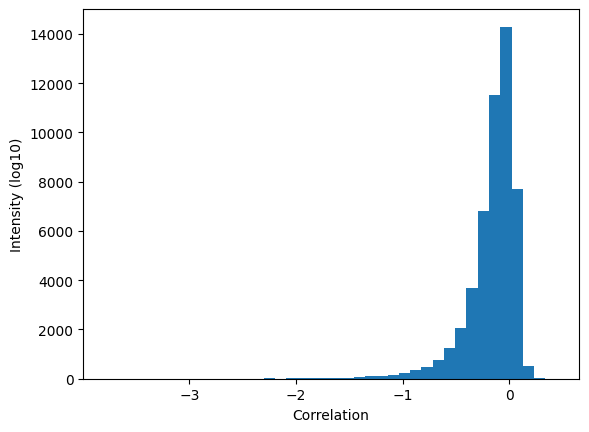

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.log10(diag + 1), bins=40)
plt.ylabel("Intensity (log10)")
plt.xlabel("Correlation")
plt.show()

In [42]:
ids = gpt2_tokenizer(' learning').input_ids
print(ids)
tok = ids[0]
# represents multiplying by S_q, a matrix with the word " learning" at position 100.
searched_by_this = M[:, tok] + M[:, GPT2_VOCAB_SIZE + 100]
ranked = searched_by_this[:GPT2_VOCAB_SIZE].argsort(descending=True)
for i in range(10):
    print(f">{gpt2_tokenizer.decode(ranked[i])} {searched_by_this[ranked[i]]:.2f}")

[4673]
> therapist 0.94
> DEBUG 0.92
>MRI 0.92
> neuroscience 0.91
> neuro 0.89
> ADHD 0.87
> psychiatrists 0.86
> Neurolog 0.86
> psychiatrist 0.85
> impair 0.85


If we put an exclamation mark, it seems to search for words that you might find in an exclamation-mark setting. Also it seems like each head searches for several correlations simultaneously.

So it seems like we can inject a word and a positional embedding to find out what is attended to, and the nice thing is that we can do all of this without ever even needing to consider the residual stream whatsoever. Also, there’s the incredibly surprising constraint that this is a completely linear function, so the contributions from the word used, and the contributions from the position of the word, are treated completely independently.

Bringing back from earlier:
$$
\begin{align*}
\text{MLPHiddenStatePreActivation}
 &= W_{mlp}^\top W_{xs} S_q + \sum_{k} \operatorname{Softmax}\left(n^{-1/2} \cdot (MS_q)^\top S_k\right) W_{mlp}^\top W_v W_{xs} S_k
\end{align*}
$$

Now we can think of this as weighting the value matrices in a certain way.
If we maintain $S_k$ separately, we note that $MLP^{(i)} = \sum_{k} AttnScore(S_k, S_q) \left((W_{mlp}^{(i)})^\top W_v W_{xs} \right) S_k$

This shows that indeed each MLP hidden neuron is just a linear function of $AttnScore(S_k, S_q) S_k$. This is, in some sense, the "kernel" of that neuron, wrt a given query ($S_q$). Why is it nice for this to be a linear function? It means that which features the MLP neurons attend to (in $S_k$) can be precomputed, and then weighted AFTERWARDS. In my opinion, this is *highly unintuitive* and represents an extreme case of independent features in the transformer.

Let me clear once more: The MLP neuron's activation proportion for a particular value vector, is INITIALLY NOT DEPENDENT ON THE QUERY VECTOR WHATSOEVER (until scaled in attention weights).


Particularly, $\nabla_{S_k} \left((W_{mlp}^{(i)})^\top W_v W_{xs} S_k \right) = W_{xs}^\top W_v^\top W_{mlp}$

In [43]:
W_mlp_per_head = torch.split(gpt2.transformer.h[0].mlp.c_fc.weight, head_dim, dim=0)

In [44]:
W_mlp_per_head[0].shape

torch.Size([64, 3072])

In [45]:
target = (W_xs.T @ value_weights_per_head[0] @ W_mlp_per_head[0])

In [64]:
# What sparse features does MLP neuron 6 look for?
neuron_num = 6
ranked = target[:, neuron_num][:GPT2_VOCAB_SIZE].argsort(descending=True)
print("::: Words :::")
for i in range(10):
    print(f">{gpt2_tokenizer.decode(ranked[i])} {target[:, neuron_num][ranked[i]]:.2f}")
print()
print("::: Positions :::")
ranked = target[:, neuron_num][GPT2_VOCAB_SIZE:].argsort(descending=True)
for i in range(10):
    print(f"pos {ranked[i]}: {target[:, neuron_num][GPT2_VOCAB_SIZE + ranked[i]]:.2f}")



::: Words :::
>achy 1.13
> syndrome 1.08
> epilepsy 1.08
> CBD 1.08
> Clinical 1.08
>EStreamFrame 1.06
>uckland 1.06
> nerv 1.05
> clinical 1.05
> neuron 1.04

::: Positions :::
pos 84: 0.30
pos 78: 0.30
pos 80: 0.30
pos 79: 0.30
pos 86: 0.29
pos 73: 0.29
pos 82: 0.29
pos 96: 0.29
pos 92: 0.29
pos 88: 0.29


# Step 3: Construct a Causal Trace

We would like to see which MLP activations are responsible for which other MLP activations. For example, the token "Hello" predicting the token " world".

To do this, we can look at the unembedding for the word " world" and see which MLP activations contribute the most. Is this invariant to the combination of activations that are provided? Well, let $e^{-1}$ be the unembedding for the word " world". Then the activation of world $\log P(world|\ldots)$ can be written as $e^{-1} \text{ResidualStream}$, which is (up to a single LayerNorm applied at the end) linear w.r.t. all MLP activations (which contribute their own little vectors towards the residual stream). So we will always have the LayerNorm caveat (If we find a better way to ensure that hidden states don't explode, we can also try finetuning an existing nn towards that).

The interesting thing is that MLP activations, word embeddings, and positional embeddings are the ONLY thing impacting the output for " world", and they can each be inspected individually.

Maybe we can call this the "sparse activation kernel" for the token " world".

(Also, I have a hunch that because most transformers use ReLU-style activations, the nonlinearities actually won't be too hurtful in most cases).

An unanswered question I have is that in huggingface's GPT-2 implementation, the layernorm doesn't actually modify the residual stream every time; it's only used at final layers. I guess this is equivalent, though, or if there are slight variations it's easy to transpose these into the same problem.

Also, here is a potential way to define the sparse space of a token's feature vector: It is the set of all possible vectors that can be added to the residual stream. This encapsulates the notion of word embeddings and positional embeddings being added to the residual stream, as well as MLP activations.


In [65]:
gpt2.transformer.h[i].mlp.c_proj.weight.shape

torch.Size([3072, 768])

In [116]:
# find the sparse activation kernel for the token "world" 
@torch.no_grad()
def get_sparse_activation_kernel(gpt2, target_vector, until_layer=12):
    hidden_kernels = []
    for i in range(until_layer):
        hidden_kernels.append(
            gpt2.transformer.h[i].mlp.c_proj.weight @ target_vector
        )
    # weight shapes: (50257 [GPT2_VOCAB_SIZE], 768 [d_model])
    word_embedding_kernel = gpt2.transformer.wte.weight @ target_vector
    pos_embedding_kernel = gpt2.transformer.wpe.weight @ target_vector
    
    return (word_embedding_kernel, pos_embedding_kernel, hidden_kernels)

In [67]:
gpt2.lm_head.weight.shape

torch.Size([50257, 768])

In [77]:
world_tok = gpt2_tokenizer(' world').input_ids[0]
hello_tok = gpt2_tokenizer('Hello').input_ids[0]
act_kernel = get_sparse_activation_kernel(gpt2, gpt2.lm_head.weight[world_tok])

## Plotting kernels

Here, we plot the "positional" kernel -- the direct contribution of each positional encoding to the word "world"'s generation likelihood. I am surprised by how smooth it is.


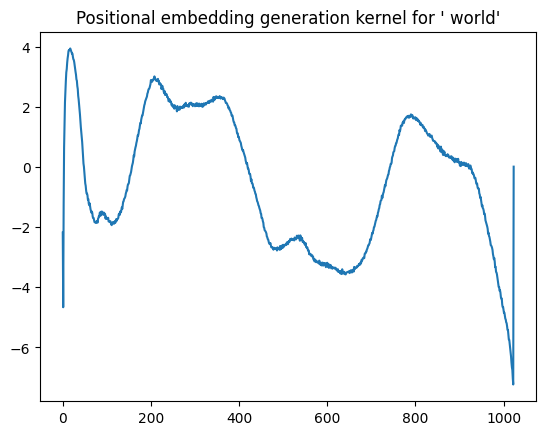

In [69]:
# plot positional kernel

import numpy as np
import matplotlib.pyplot as plt

word_embedding_kernel, pos_embedding_kernel, hidden_kernels = act_kernel

plt.title("Positional embedding generation kernel for ' world'")
plt.plot(pos_embedding_kernel.detach().cpu().numpy())
plt.show()


Now let's look at what words are most correlated with generating ' world'. We see a range of words that seem to be semantically similar (which I guess is what we might expect at the highest level).

In [70]:
ranked = word_embedding_kernel.argsort(descending=True)
print("::: Words :::")
for i in range(20):
    print(f">{gpt2_tokenizer.decode(ranked[i])} {word_embedding_kernel[ranked[i]]:.2f}")

::: Words :::
> world 20.26
> WORLD 18.25
>world 17.73
> worlds 17.61
>World 17.05
> mathemat 17.02
> globe 16.99
> millenn 16.83
> challeng 16.62
> tremend 16.62
> universe 16.43
> conflic 16.32
> World 16.22
> enthusi 16.12
> neighb 16.11
>senal 16.06
> encount 15.98
> conclud 15.97
> unden 15.94
> livest 15.93


In [71]:
# Now, let's see if we can figure out the most salient MLP activations
for i in range(len(hidden_kernels)):
    top_10 = hidden_kernels[i].argsort(descending=True)[:10]
    print("Layer", i)
    print("Top 10 ranks")
    print(top_10.tolist())
    print("Logit offset per unit of activation")
    print(hidden_kernels[i][top_10].cpu().numpy())


Layer 0
Top 10 ranks
[2947, 486, 800, 450, 3065, 1948, 802, 678, 1401, 933]
Logit offset per unit of activation
[4.5515857 3.5348296 3.462263  3.4285254 3.2951808 3.225283  3.127183
 3.115718  3.099147  2.89163  ]
Layer 1
Top 10 ranks
[8, 1675, 2814, 1652, 2450, 107, 2720, 2309, 1781, 2440]
Logit offset per unit of activation
[8.459323  4.3932323 3.3828032 3.2918189 3.233506  3.1199784 2.947613
 2.9233322 2.853726  2.8421643]
Layer 2
Top 10 ranks
[2631, 2051, 2027, 1651, 2198, 3037, 1681, 1328, 2315, 1611]
Logit offset per unit of activation
[6.841717  5.04234   4.665663  4.40021   3.9743469 3.8107488 3.7076836
 3.5124412 3.4829688 3.0682342]
Layer 3
Top 10 ranks
[1616, 1792, 1235, 3054, 1921, 2413, 748, 489, 509, 2547]
Logit offset per unit of activation
[3.9193954 3.8351953 3.5292473 3.4618466 3.4280593 3.3627706 3.2452142
 3.1960106 3.1856818 3.073351 ]
Layer 4
Top 10 ranks
[1590, 1100, 2381, 1404, 2982, 2963, 1862, 1105, 1594, 513]
Logit offset per unit of activation
[5.469589  4.6

## Peeling back the layers

It seems like layer 11 (the last layer) is, in general, the strongest contributor to the token " world", with neuron 541 providing +48.16 activation per unit of activation. (I guess we do still need to consider LayerNorm! But the prior activations are significantly weaker still.)


In [141]:
def get_qkv_and_mlp_weights(gpt2, layer_num):
    qkv_weight = gpt2.transformer.h[layer_num].attn.c_attn.weight
    # torch.split returns "views", which are more memory-efficient than creating slices I think
    query_weights, key_weights, value_weights = torch.split(qkv_weight, split_size, dim=-1)
    
    query_weights_per_head = torch.split(query_weights, head_dim, dim=-1)
    key_weights_per_head = torch.split(key_weights, head_dim, dim=-1)
    value_weights_per_head = torch.split(key_weights, head_dim, dim=-1)
    
    W_mlp_per_head = torch.split(gpt2.transformer.h[layer_num].mlp.c_fc.weight, head_dim, dim=0)
    
    return (query_weights_per_head, key_weights_per_head, value_weights_per_head, W_mlp_per_head)

In [157]:
def visualize_kernel(kernel):
    word_embedding_kernel, pos_embedding_kernel, hidden_kernels = kernel
    ranked = word_embedding_kernel.argsort(descending=True)
#     print("::: What word embeddings trigger this? :::")
#     for i in range(25):
#         print(f">{gpt2_tokenizer.decode(ranked[i])} {word_embedding_kernel[ranked[i]]:.2f}")
        
#     print("::: What Positional embeddings trigger this? :::")
#     ranked = pos_embedding_kernel.argsort(descending=True)
#     for i in range(10):
#         print(f"pos {ranked[i]}: {pos_embedding_kernel[ranked[i]]:.2f}")

    # Now, let's see if we can figure out the most salient MLP activations
    print("::: What prior MLP neurons trigger this? :::")
    k = 1
    for i in range(len(hidden_kernels)):
        top_k = hidden_kernels[i].argsort(descending=True)[:k]
        print("Layer", i)
        print(f"Top {k} ranks")
        print(top_k.tolist())
        print("Logit offset per unit of activation")
        print(hidden_kernels[i][top_k].cpu().numpy())


In [158]:
# this is what the MLP neuron activates for (only tracing for this particular head though)
layer = 11
neuron = 541
query_weights_per_head, key_weights_per_head, value_weights_per_head, W_mlp_per_head = get_qkv_and_mlp_weights(gpt2, layer)

for head in range(12):
    print("HEAD", head)
    residual_stream_MLP_target = value_weights_per_head[head] @ W_mlp_per_head[head][:, neuron]
    # residual_stream_MLP_target = gpt2.lm_head.weight[world_tok]
    kernel = get_sparse_activation_kernel(gpt2, residual_stream_MLP_target, until_layer=12)
    visualize_kernel(kernel)


HEAD 0
::: What prior MLP neurons trigger this? :::
Layer 0
Top 1 ranks
[2496]
Logit offset per unit of activation
[0.5958279]
Layer 1
Top 1 ranks
[962]
Logit offset per unit of activation
[0.2955079]
Layer 2
Top 1 ranks
[2942]
Logit offset per unit of activation
[0.22707301]
Layer 3
Top 1 ranks
[41]
Logit offset per unit of activation
[0.21945603]
Layer 4
Top 1 ranks
[2253]
Logit offset per unit of activation
[0.3362456]
Layer 5
Top 1 ranks
[1206]
Logit offset per unit of activation
[0.20363009]
Layer 6
Top 1 ranks
[1824]
Logit offset per unit of activation
[0.23731661]
Layer 7
Top 1 ranks
[1540]
Logit offset per unit of activation
[0.28071463]
Layer 8
Top 1 ranks
[2560]
Logit offset per unit of activation
[0.27562135]
Layer 9
Top 1 ranks
[3026]
Logit offset per unit of activation
[0.29333735]
Layer 10
Top 1 ranks
[1276]
Logit offset per unit of activation
[0.5318454]
Layer 11
Top 1 ranks
[2728]
Logit offset per unit of activation
[0.4697923]
HEAD 1
::: What prior MLP neurons trigger 

### Now let's see if we can figure out what *earlier* neurons contribute to THIS one! It seems that layer 0, neuron 2496 triggers this neuron's activation from the value-vector side. What does *this* neuron look for?

Realizing that part of the difficulty of mechanistic interpretability is figuring out what individual MLP neurons are responsible for in an encapsulated way. But maybe a forward-facing approach will work well.

`world_tok, hello_tok = 995, 15496`


In [120]:
query_weights_per_head, key_weights_per_head, value_weights_per_head, W_mlp_per_head = get_qkv_and_mlp_weights(gpt2, 0)

In [128]:
for head in range(12):
    print("HEAD", head)
    residual_stream_MLP_target = value_weights_per_head[head] @ W_mlp_per_head[head][:, 2496]
    kernel = get_sparse_activation_kernel(gpt2, residual_stream_MLP_target, until_layer=0)
    visualize_kernel(kernel)

HEAD 0
::: What word embeddings trigger this? :::
>agos 0.34
>ersion 0.32
>IENT 0.32
>eps 0.32
>Fit 0.30
>arial 0.30
>portion 0.30
>arella 0.30
>illard 0.30
>ć 0.30
>ITH 0.29
>igree 0.29
>ppo 0.28
>FM 0.28
> OECD 0.28
> AHL 0.28
>ée 0.28
> posterior 0.28
> Pixel 0.28
>rection 0.27
>inar 0.27
> appealed 0.27
>ersed 0.27
>ient 0.27
> Tiff 0.27
::: What Positional embeddings trigger this? :::
pos 624: 0.10
pos 604: 0.10
pos 637: 0.10
pos 611: 0.10
pos 625: 0.10
pos 631: 0.10
pos 635: 0.10
pos 626: 0.10
pos 629: 0.10
pos 628: 0.10
::: What prior MLP neurons trigger this? :::
HEAD 1
::: What word embeddings trigger this? :::
>zynski 0.36
>henko 0.34
> Sr 0.32
> reportedly 0.32
> Frem 0.32
>worth 0.32
>bourg 0.31
>enegger 0.31
> Diaz 0.30
> namesake 0.30
>zinski 0.29
>zech 0.29
>coni 0.28
> Annotations 0.28
> classmate 0.28
> prestigious 0.27
> esteemed 0.27
> agreeing 0.27
> illustrious 0.27
> Lans 0.27
>arov 0.27
>andestine 0.27
> ATK 0.27
> agreed 0.26
> birthday 0.26
::: What Positional 